In [17]:
import torch as pt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from matplotlib.pylab import plt
import numpy as np

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


torch.Size([65536, 2, 5])


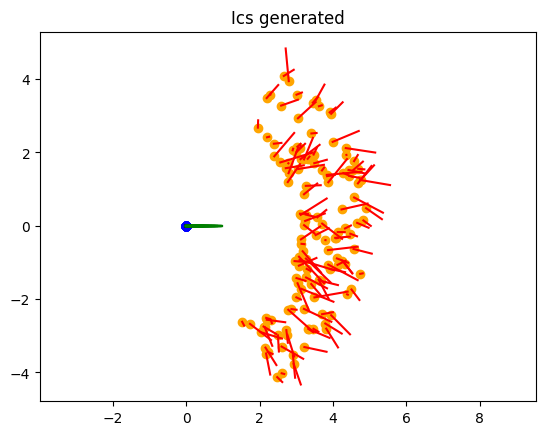

In [11]:
def create_ics(shape=(1,)):
    _0 = pt.zeros(shape)
    def R(min=0, max=1):
        return min + (max - min)*pt.rand(shape)
    
    x0 = _0
    y0 = _0
    a0 = _0
    s0 = R(0, 1)
    w0 = R(-0.5, 0.5)

    R1 = R(3, 5)
    T1 = R(-pt.pi/3, pt.pi/3)
    x1 = R1 * pt.cos(T1)
    y1 = R1 * pt.sin(T1)
    a1 = R(-pt.pi/4, pt.pi/4) + pt.arctan2(y1, x1)
    s1 = R(0, 1)
    w1 = R(-0.5, 0.5)

    return pt.stack([
        pt.stack([x0, y0, a0, s0, w0], dim=-1), # v0
        pt.stack([x1, y1, a1, s1, w1], dim=-1), # target   
    ], dim=-2)

ics = create_ics((2**16))
print(ics.shape)

plt.scatter(ics[:128,0,0], ics[:128,0,1], c='blue')
plt.scatter(ics[:128,1,0], ics[:128,1,1], c='orange')

x0 = ics[:128,0,0]
dx0 = ics[:128,0,3]*pt.cos(ics[:128,0,2])
y0 = ics[:128,0,1]
dy0 = ics[:128,0,3]*pt.sin(ics[:128,0,2])

x1 = ics[:128,1,0]
dx1 = ics[:128,1,3]*pt.cos(ics[:128,1,2])
y1 = ics[:128,1,1]
dy1 = ics[:128,1,3]*pt.sin(ics[:128,1,2])

plt.plot(pt.stack([x0, x0+dx0]), pt.stack([y0, y0+dy0]), c='green')
plt.plot(pt.stack([x1, x1+dx1]), pt.stack([y1, y1+dy1]), c='red')
plt.title('Ics generated')
plt.axis('equal')
plt.show()

In [3]:
def showTraj(V_mat, F_mat, ts, target, figaxs=None, show=True, wait=False, ax1_Title='Trajectory', alpha=0.5):
    if figaxs is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    else:
        fig, (ax1, ax2) = figaxs

    VS = V_mat.detach().cpu().numpy() if isinstance(V_mat, pt.Tensor) else np.stack([_.detach() for _ in V_mat])
    FS = F_mat.detach().cpu().numpy()

    # lw = 2 if alpha == 1 else 0.75+alpha
    lw = 2 if alpha == 1 else 1.5

    ax1.plot(VS[:,0], VS[:,1], lw=lw, zorder=6, color='dodgerblue', alpha=alpha)

    ax2.plot(ts[:-1], FS[:,0], 'deeppink', lw=lw, alpha=alpha, label='Acceleration Force' if show and not wait else None)
    ax2.plot(ts[:-1], FS[:,1], 'limegreen', lw=lw, alpha=alpha, label='Turning Force' if show and not wait else None)


    if show:
        ax1.scatter(VS[0,0], VS[0,1], marker='*', color='sandybrown', s=200, zorder=6, alpha=alpha, label='Start' if not wait else None)
        ax1.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, alpha=alpha, label='Target' if not wait else None)
        if alpha != 0:
            ax1.scatter(VS[-1,0], VS[-1,1], marker='o', color='dodgerblue', s=60, zorder=10, alpha=alpha, label='End' if not wait else None)

        arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

        ax1.arrow(*VS[-1,0:2], *arrowDir(VS[-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3, alpha=alpha)
        ax1.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=3, zorder=2, alpha=alpha)
        ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2, alpha=alpha)
        # ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)

        if not wait:
            ax1.set_title(ax1_Title)
            ax1.set_xlabel('X Position')
            ax1.set_ylabel('Y Position')
            ax1.axis('equal')
            ax1.grid()
            ax1.legend()

            ax2.plot([0, 10], [-0.8, -0.8], '--k')
            ax2.plot([0, 10], [0.8, 0.8], '--k')
            ax2.legend()
            ax2.set_title('Forcing Terms')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Force')
            ax2.set_xlim([0, ts[-1]*1.1])
            ax2.set_ylim([-0.85, 0.85])
            ax2.grid()
            plt.show()

    return fig, (ax1, ax2)

In [38]:
def V_step(V, F):
    phi = F[...,0][:, pt.newaxis]  # linear acceleration
    psi = F[...,1][:, pt.newaxis]  # angluar acceleration
    dt = F[...,2][:, pt.newaxis]   # timestep size

    dt2 = dt*dt/2

    x = V[...,0]    # x coordinate
    y = V[...,1]    # y coordinate
    a = V[...,2]    # angle
    s = V[...,3]    # speed
    w = V[...,4]    # angular speed
    t = V[...,5]    # time

    _0 = pt.zeros_like(x, device=V.device)
    _1 = pt.ones_like(x, device=V.device)

    A1 = pt.stack([x, y, a, s, w, t], axis=-1)
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0], axis=-1)
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0], axis=-1)
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0], axis=-1)
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0], axis=-1)
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0], axis=-1)
    C3 = pt.stack([_0, _0, _1, _0, _0, _0], axis=-1)
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1], axis=-1)  # this is correct

    return A + phi*B + psi*C + dt*D

def angle_diff(theta1, theta2):
    diff = theta1 - theta2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def loss_fun(Y, T, F, scale=None):
    scale = pt.ones([1, 1, 1, 1, 1], device=Y.device)[pt.newaxis,:] if scale is None else scale
    diff = (Y[...,0:5]-T)
    diff[...,2] = angle_diff(Y[...,2], T[...,2])
    target_loss = pt.sum(diff * diff * scale, dim=(-2, -1))     # loss from missing the target
    time_loss = Y[...,5]                                        # loss by taking too long
    l2_loss = pt.mean(F[...,:,0:2]**2)                          # loss by using too much force
    return target_loss, time_loss, l2_loss


def compute_path_autograd(V0, F_mat, target):
    # print(f'V0 shape = {V0.shape}')
    # print(f'target shape = {target.shape}')
    # print(f'F_mat shape = {F_mat.shape}')

    V_list = [V0]   # trajectory as a list of position vectors
    for i in range(F_mat.shape[-2]):
        V_list.append(V_step(V_list[i], F_mat[...,i,:]))

    loss = loss_fun(V_list[-1], target, F_mat)

    return V_list, loss

def to_tensor(V_mat):
    batch_size = V_mat[0].shape[0]
    n_steps = len(V_mat)
    num_dims = V_mat[0].shape[-1]

    ten = pt.zeros((batch_size, n_steps, num_dims), device=V_mat[0].device)
    for i in range(n_steps):
        ten[...,i,:] = V_mat[i].detach().cpu()
    return ten[...,0:5], ten[...,5]

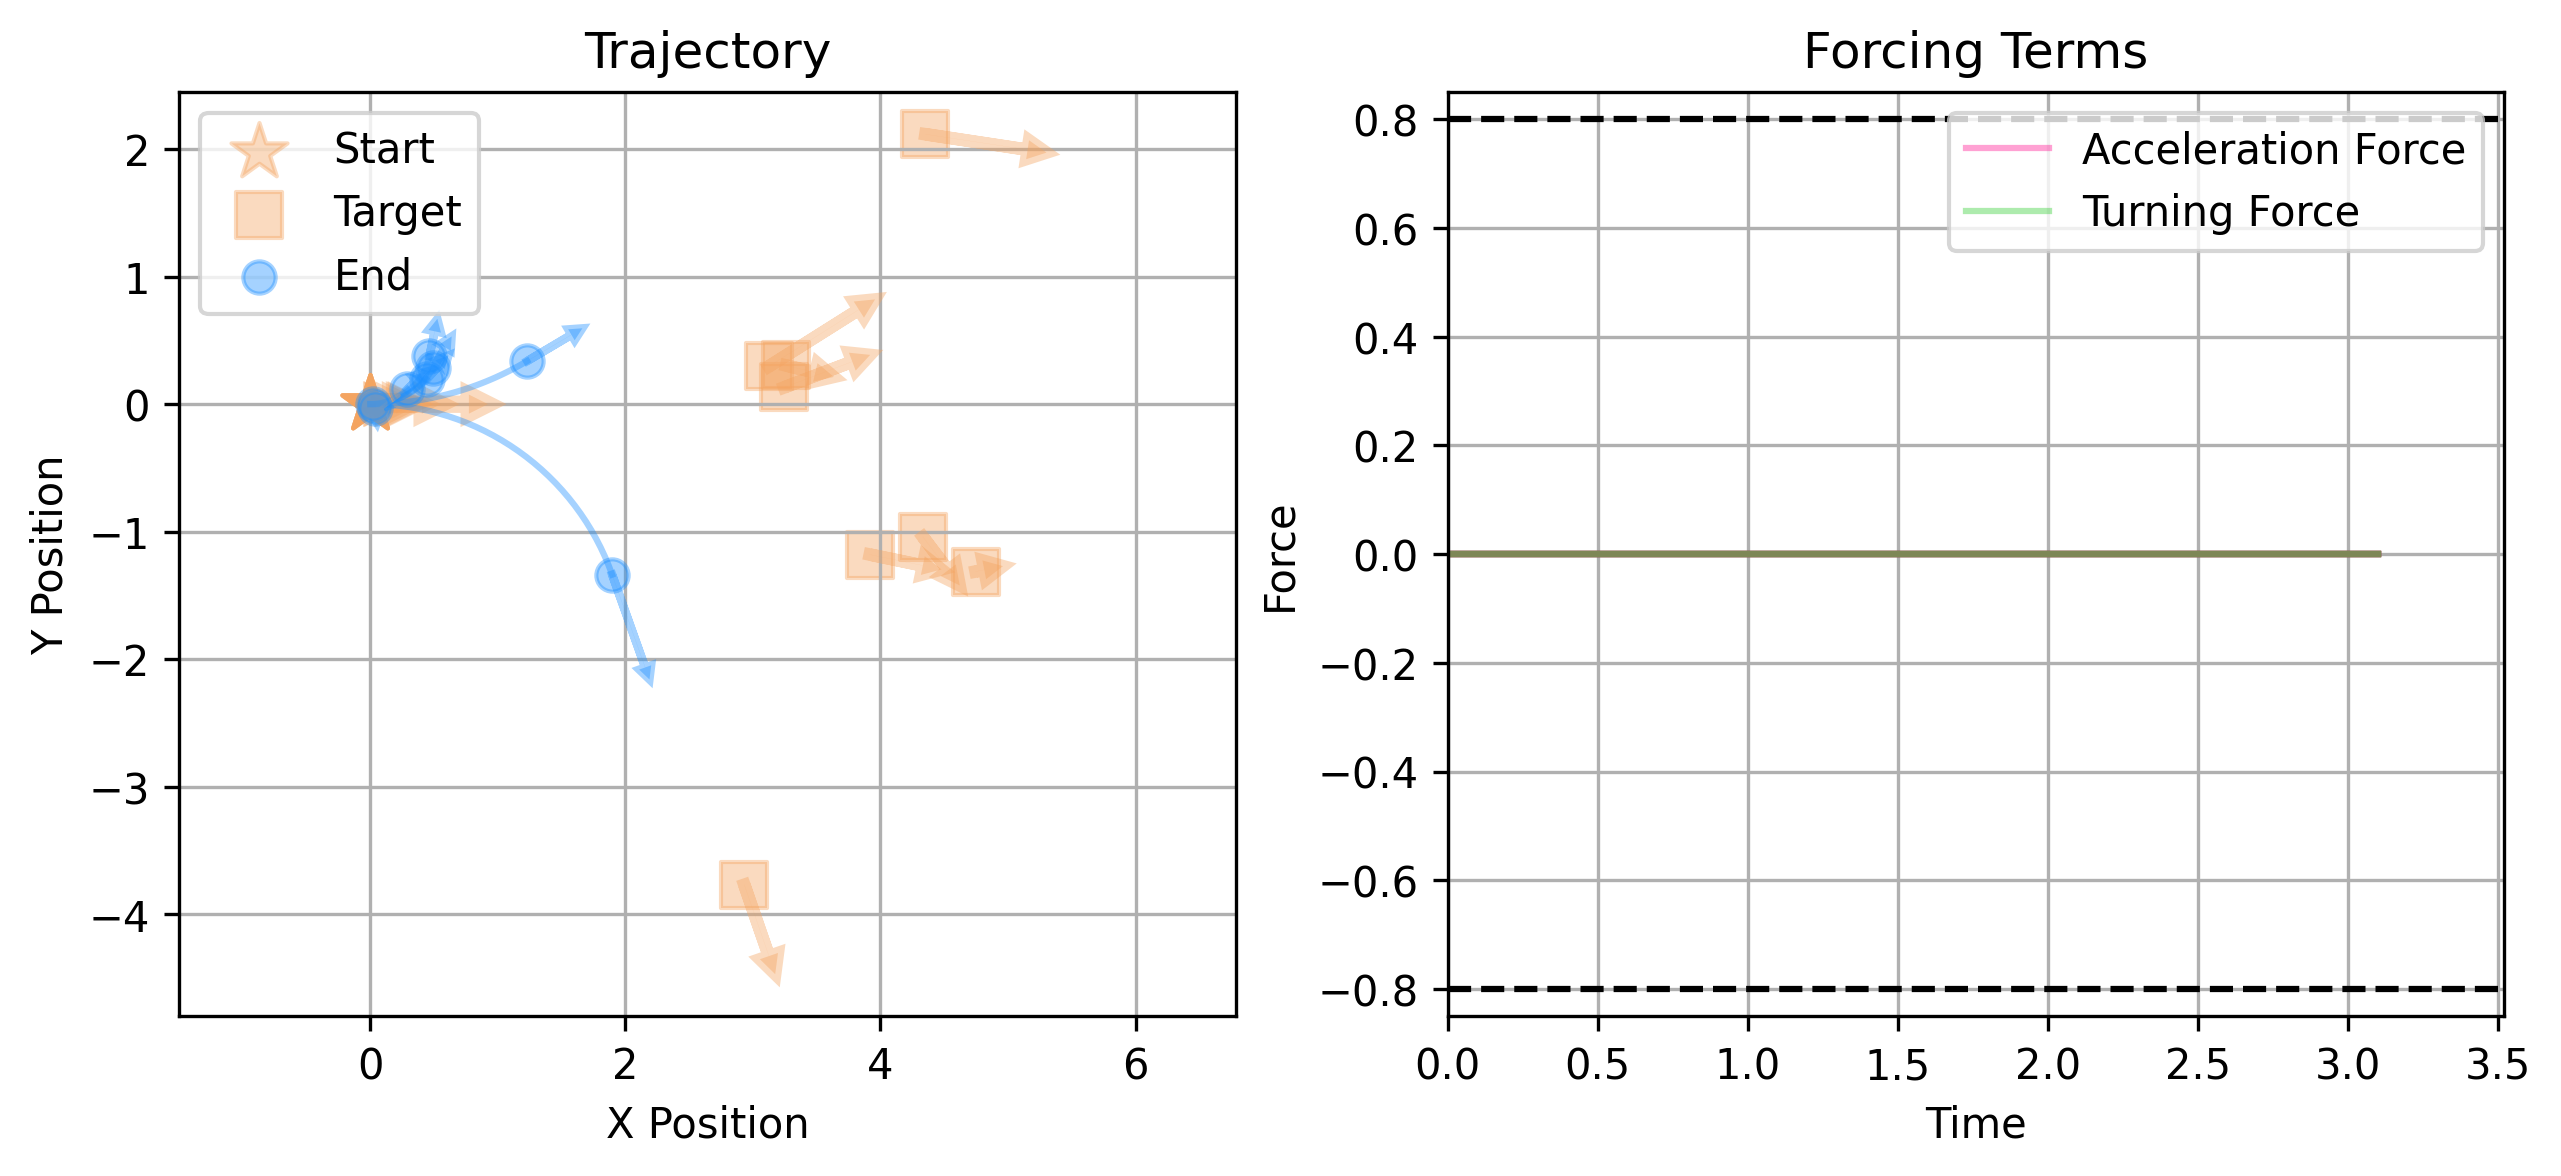

In [56]:
batch_size  =   2**16
n_steps     =   32

pt.cuda.empty_cache()
pt.cuda.ipc_collect()

v0 = pt.cat([ics[:batch_size,0], pt.zeros_like(ics[:batch_size,0:1,0])], dim=1).to(device)
target = ics[:batch_size,1].to(device)
F_mat = (pt.ones((batch_size, n_steps, 3)) * pt.tensor([0, 0, 0.1])[pt.newaxis, pt.newaxis, :]).to(device)

V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

traj, ts = to_tensor(V_mat)

figaxs = None
for i in range(8):
    figaxs = showTraj(traj[i].cpu(), F_mat[i].cpu(), ts[i].cpu(), target[i].cpu(), figaxs=figaxs, show=True, wait=i!=8-1, alpha=0.4)

In [57]:
class ICSDataset(Dataset):
    def __init__(self, data):
        self.len = data.shape[0]
        self.v0 = pt.cat([data[:,0], pt.zeros_like(data[:,0:1,0])], dim=1)
        self.target = ics[:,1]  

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.v0[idx], self.target[idx]
    
total_len = min(len(ics), 2**14)
dataset = ICSDataset(ics[:total_len])

train_len = int(0.7 * total_len)
val_len   = int(0.15 * total_len)
test_len  = total_len - train_len - val_len

print(f'Train: {train_len}, Val: {val_len}, Test: {test_len}')

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False)

Train: 11468, Val: 2457, Test: 2459


In [58]:
class MLP(nn.Module):
    def __init__(self, input_dim=5, output_dim=32, latent_dim=64, device=device):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),                                               # (b, 2, 5) -> (b, 10)
            nn.Linear(input_dim*2, latent_dim),                         # layer 1
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),                          # layer 2
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),                          # layer 3
            nn.ReLU(),
            nn.Linear(latent_dim, output_dim*3),                        # layer 4
            nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(output_dim, 3))       # (b, 32, 3) output normalized 0 to 1
        )

        self.register_buffer('limits', pt.tensor([[-0.8, -0.8, 0.01], [0.8, 0.8, 0.25]]).T.unsqueeze(0))


    def forward(self, v0, target):
        x = pt.stack([v0[...,:-1], target], dim=-2)
        x = self.layers(x)
        mins = self.limits[0:1, 0:1, 0]
        maxes = self.limits[0:1, 0:1, 1]
        x = x * (maxes - mins) + mins
        return x



In [59]:
mlp = MLP(latent_dim=64).to(device)

optimizer = pt.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-3)

losses = []
num_epochs = 30
for epoch in range(num_epochs):
    mlp.train()
    train_loss = 0.0
    val_loss = 0.0

    # Train
    for batch, (v0, target) in enumerate(train_loader):
        v0, target = v0.to(device), target.to(device)

        # Foward
        F_mat = mlp(v0, target)
        V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

        # Backward
        optimizer.zero_grad()
        target_loss.backward()
        optimizer.step()

        train_loss += target_loss.item()
    train_avg = train_loss / len(train_loader)

    # Val
    with pt.no_grad():
        for batch, (v0, target) in enumerate(train_loader):
            v0, target = v0.to(device), target.to(device)

            # Foward
            F_mat = mlp(v0, target)
            V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

            val_loss += target_loss.item()
    val_avg = val_loss / len(val_loader)

    losses.append([train_avg, val_avg])
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_avg:.4f}, Val Loss: {val_avg:.4f}")

plt.plot(np.array(losses))

Epoch 1/30, Train Loss: 239.8553, Val Loss: 3342.8920
Epoch 2/30, Train Loss: 33.9753, Val Loss: 1277.8633
Epoch 3/30, Train Loss: 16.9214, Val Loss: 855.1072
Epoch 4/30, Train Loss: 11.9136, Val Loss: 709.6067
Epoch 5/30, Train Loss: 9.5043, Val Loss: 830.1992
Epoch 6/30, Train Loss: 6.6286, Val Loss: 291.4059
Epoch 7/30, Train Loss: 3.4259, Val Loss: 344.4233
Epoch 8/30, Train Loss: 2.5648, Val Loss: 196.8452
Epoch 9/30, Train Loss: 2.2075, Val Loss: 156.7447
Epoch 10/30, Train Loss: 1.8656, Val Loss: 109.3584
Epoch 11/30, Train Loss: 1.6761, Val Loss: 153.5272
Epoch 12/30, Train Loss: 1.4982, Val Loss: 98.8230
Epoch 13/30, Train Loss: 1.2629, Val Loss: 76.0599
Epoch 14/30, Train Loss: 1.1873, Val Loss: 104.9461
Epoch 15/30, Train Loss: 1.1764, Val Loss: 45.3226
Epoch 16/30, Train Loss: 0.8848, Val Loss: 99.3381
Epoch 17/30, Train Loss: 1.1355, Val Loss: 58.2960
Epoch 18/30, Train Loss: 0.8650, Val Loss: 65.7746
Epoch 19/30, Train Loss: 1.0283, Val Loss: 99.3468


KeyboardInterrupt: 